## Setting Up

In [1]:
import os
import glob
import random
from tqdm import tqdm

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image
import pytesseract
import pickle

In [3]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"


ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(ROOT_DIR, "data")
OUTPUT_DIR = os.path.join(ROOT_DIR, "backend", "model")

os.makedirs(OUTPUT_DIR, exist_ok=True)

seed = 0
random.seed(seed)

## Prepare Data

In [8]:
CONVERTED_DIR = os.path.join(DATA_DIR, "data_png")
os.makedirs(CONVERTED_DIR, exist_ok=True)

def convert_tiff_to_png(src_dir=DATA_DIR, dst_dir=CONVERTED_DIR):
    """Convert all TIFFs in dataset to PNG (multi-page safe)."""
    for label in os.listdir(src_dir):
        label_dir = os.path.join(src_dir, label)
        if not os.path.isdir(label_dir):
            continue

        out_label_dir = os.path.join(dst_dir, label)
        os.makedirs(out_label_dir, exist_ok=True)

        files = glob.glob(os.path.join(label_dir, "*.tif"))
        for f in tqdm(files, desc=f"Processing class '{label}'"):
            try:
                img = Image.open(f)
                for i in range(img.n_frames):
                    img.seek(i)
                    base = os.path.splitext(os.path.basename(f))[0]
                    out_path = os.path.join(out_label_dir, f"{base}_p{i}.png")
                    img.save(out_path, format="PNG")
            except Exception as e:
                print(f"Failed {f}: {e}")
                pass
    print(f"Conversion done. PNGs stored in {dst_dir}")

convert_tiff_to_png()

Processing class 'data_png': 0it [00:00, ?it/s]
Processing class 'resume': 100%|██████████| 2536/2536 [00:55<00:00, 45.67it/s]

Conversion done. PNGs stored in d:\work\ITI\workshop project\document analyzer\data\data_png


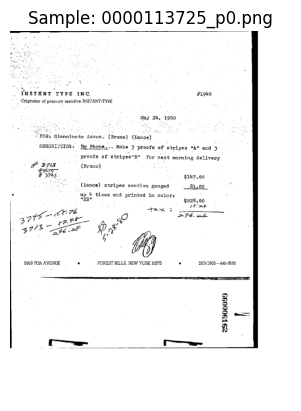

In [9]:
from typing import Union
import matplotlib.pyplot as plt

def read_and_show_image(path: str) -> None:
    """Open a file and display it."""
    img = Image.open(path)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Sample: {os.path.basename(path)}")
    plt.show()

sample_path = glob.glob(os.path.join(CONVERTED_DIR, "invoice", "*.png"))[5]
read_and_show_image(sample_path)


In [10]:
def ocr_image(path: str) -> str:
    """Extract text from a single image file."""
    img = Image.open(path)
    text = pytesseract.image_to_string(img)
    return text.strip()

print(ocr_image(sample_path)[:500])


INSTANT TYPE INC Fgh
Otiginater of presyaze sensitive INSTANT-TYPE

May 2, 1980

FOR! Gianninoto Asse. (Bruno) (Lance)
DESCRIZIION: By Phone... Wake 3 proofs of stripes “A" and 3
proofs of stripes"E" for next morning delivery

wf 278 (Bruno)
¥ 3745 $147.00
~ Qance) stripes section ganged 81,00 “
up 4 tines and printed in colors
"2B" $228,00
ax: ie
pth OE Pe) SPESE
as (37 ee D of
3708 Nom
9918 70h AVENUE . ST HILLS. NEW YORK 11975 . 269-2916—4411836

a

297900099


In [11]:
for cls in os.listdir(CONVERTED_DIR):
    n = len(os.listdir(os.path.join(CONVERTED_DIR, cls)))
    print(f"Class '{cls}': {n} samples")

Class 'email': 2516 samples
Class 'invoice': 2477 samples
Class 'resume': 2536 samples


In [13]:
def build_dataset(data_dir: str) -> pd.DataFrame:
    """OCR all images in data_dir, return DataFrame with text + label."""
    records = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            continue
        files = glob.glob(os.path.join(label_dir, "*.png"))
        for f in tqdm(files, desc=f"Processing {label}"):
            text = ocr_image(f)
            records.append({"text": text, "label": label})
            
        print(f"Processed {len(files)} files for class '{label}'")
    return pd.DataFrame(records)

df = build_dataset(CONVERTED_DIR)
df.head()

Processing email:   0%|          | 0/2516 [00:00<?, ?it/s]

Processing email: 100%|██████████| 2516/2516 [18:48<00:00,  2.23it/s]


Processed 2516 files for class 'email'


Processing invoice:  51%|█████     | 1257/2477 [10:59<10:39,  1.91it/s]


KeyboardInterrupt: 

In [18]:
df = pd.read_csv(os.path.join(DATA_DIR, "dataset.csv"))

In [25]:
df.sample(5, random_state=seed)

,text,label
4642,BIOGRAPHICAL SKETCH\nGive the folowing informa...,resume
7470,"BGTC Help Desk\n\nMonday, May 03, 1999 12:52 P...",email
5328,"Fleming, Jetey\nFW: January NSM\n\nDraft Agend...",email
4309,Biographical Sketch\n(give the following infor...,resume
72,"BORRISTON\n\nLABORATORIES, INC.\n\norrston Lal...",invoice


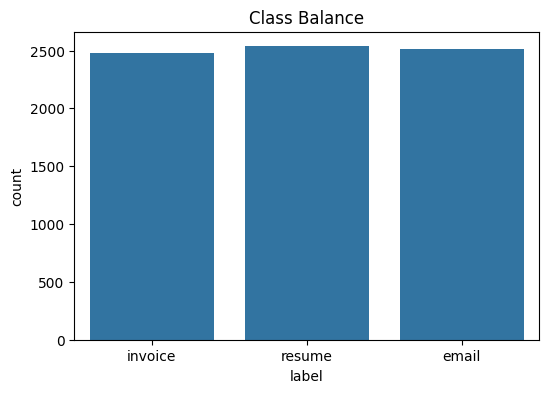

In [26]:
import seaborn as sns

def plot_class_balance(data: pd.DataFrame):
    plt.figure(figsize=(6,4))
    sns.countplot(x="label", data=data)
    plt.title("Class Balance")
    plt.show()

plot_class_balance(df)

In [ ]:
DATASET_PATH = os.path.join(ROOT_DIR, "data", "dataset.csv")

def save_dataset(df: pd.DataFrame, path: str = DATASET_PATH):
    df.to_csv(path, index=False)
    print(f"Dataset saved to {path}")

save_dataset(df)


✅ Dataset saved to /home/administrator/test/pdf/data/dataset.csv


## Vectorize & Train

In [31]:
def vectorize_texts(df: pd.DataFrame):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    df.dropna(subset=["text"], inplace=True)
    X = vectorizer.fit_transform(df["text"])
    y = df["label"]
    return X, y, vectorizer

X, y, vectorizer = vectorize_texts(df)
print("Vectorization complete:", X.shape)

Vectorization complete: (7504, 5000)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (6753, 5000), Test: (751, 5000)


In [33]:
def train_classifier(X_train, y_train):
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    return clf

clf = train_classifier(X_train, y_train)
print("Model training complete")

Model training complete


In [34]:
y_pred = clf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

       email       0.98      0.97      0.98       252
     invoice       0.94      0.98      0.96       246
      resume       0.98      0.96      0.97       253

    accuracy                           0.97       751
   macro avg       0.97      0.97      0.97       751
weighted avg       0.97      0.97      0.97       751

=== Confusion Matrix ===
[[244   8   0]
 [  0 242   4]
 [  4   7 242]]


In [35]:
def save_artifacts(model, vectorizer, out_dir=OUTPUT_DIR):
    model_path = os.path.join(out_dir, "trained_model.pkl")
    vec_path = os.path.join(out_dir, "vectorizer.pkl")

    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    with open(vec_path, "wb") as f:
        pickle.dump(vectorizer, f)

    print(f"Saved model to {model_path}")
    print(f"Saved vectorizer to {vec_path}")

save_artifacts(clf, vectorizer)

Saved model to d:\work\ITI\workshop project\document analyzer\backend\model\trained_model.pkl
Saved vectorizer to d:\work\ITI\workshop project\document analyzer\backend\model\vectorizer.pkl


In [39]:
def predict_sample(text: str, model, vectorizer):
    X = vectorizer.transform([text])
    return model.predict(X)[0]

sample_text = df.iloc[3500]["text"]
print("Sample text prediction:", predict_sample(sample_text, clf, vectorizer))

Sample text prediction: resume
